In [ ]:
# 安装transformers库
!pip install transformers datasets


In [5]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # 改从torch.optim导入
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [9]:
# 第一步：数据加载和基本检查
import pandas as pd
import numpy as np

print("第一步：数据加载和基本检查")
print("=" * 50)

# 定义列名
column_names = ['polarity', 'title', 'text']

# 读取数据
print("正在读取数据...")
train_df = pd.read_csv('train.csv', names=column_names, nrows=10000)  # 读取前10000行
dev_df = pd.read_csv('dev.csv', names=column_names)
test_df = pd.read_csv('test.csv', names=column_names)

print(f"✓ 训练集: {len(train_df)} 条")
print(f"✓ 验证集: {len(dev_df)} 条")
print(f"✓ 测试集: {len(test_df)} 条")

# 显示前几行数据
print("\n训练集前3行数据:")
print(train_df.head(3))
print("\n验证集前3行数据:")
print(dev_df.head(3))
print("\n测试集前3行数据:")
print(test_df.head(3))

# 检查数据类型
print("\n训练集数据类型:")
print(train_df.dtypes)

# 检查是否有缺失值
print("\n缺失值检查:")
print("训练集缺失值:")
print(train_df.isnull().sum())
print("\n验证集缺失值:")
print(dev_df.isnull().sum())
print("\n测试集缺失值:")
print(test_df.isnull().sum())

# 查看标签分布
print("\n标签分布 (原始):")
print("训练集 - 负面(1):", sum(train_df['polarity'] == 1), "正面(2):", sum(train_df['polarity'] == 2))
print("验证集 - 负面(1):", sum(dev_df['polarity'] == 1), "正面(2):", sum(dev_df['polarity'] == 2))
print("测试集 - 负面(1):", sum(test_df['polarity'] == 1), "正面(2):", sum(test_df['polarity'] == 2))

print("\n✓ 第一步完成：数据加载成功！")

第一步：数据加载和基本检查
正在读取数据...
✓ 训练集: 10000 条
✓ 验证集: 1001 条
✓ 测试集: 1001 条

训练集前3行数据:
   polarity                                  title  \
0         2         Stuning even for the non-gamer   
1         2  The best soundtrack ever to anything.   
2         2                               Amazing!   

                                                text  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  

验证集前3行数据:
   polarity                                        title  \
0         2                                     Great CD   
1         2  Book Still Gets Five Stars but One for Frey   
2         2                              Entertaining...   

                                                text  
0  My lovely Pat has one of the GREAT voices of h...  
1  When I read this book a year ago, I found some...  
2  After reading some of the negative reviews, I ...  

测试集前3行数据:
  


第二步：数据预处理和准备
1. 转换标签格式 (1->0:负面, 2->1:正面)...
✓ 标签转换完成
训练集标签分布 - 负面(0): 4903 正面(1): 5097
验证集标签分布 - 负面(0): 490 正面(1): 511
测试集标签分布 - 负面(0): 507 正面(1): 494

2. 合并title和text创建完整评论...
✓ 合并完成
示例评论 (前150字符):
Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate v ...

3. 清洗文本...
✓ 文本清洗完成
清洗后示例 (前150字符):
Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate v ...

4. 分析文本长度分布...
训练集文本长度统计（单词数）:
  最短: 14 个单词
  最长: 212 个单词
  平均: 79.6 个单词
  中位数: 71.0 个单词
  95%分位数: 162.0 个单词


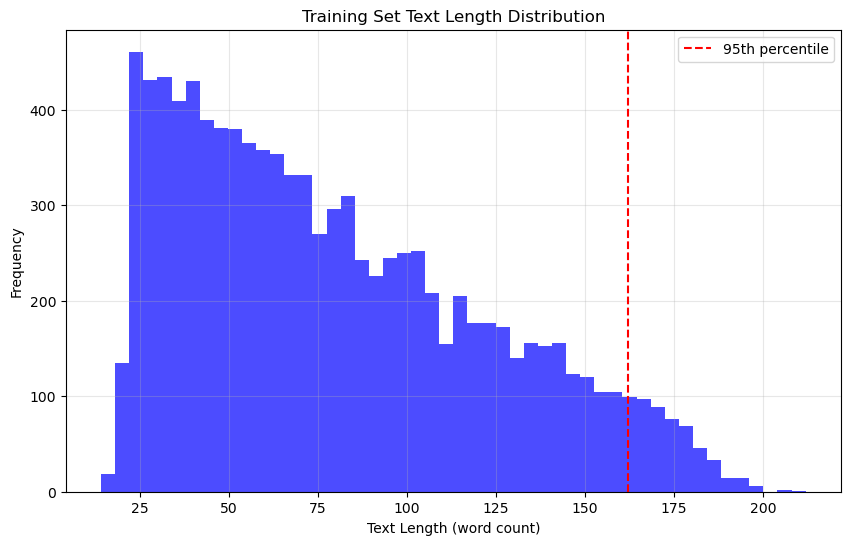


5. 准备训练、验证、测试数据...
✓ 数据准备完成
训练集: 10000 条
验证集: 1001 条
测试集: 1001 条

6. 检查类别平衡...
训练集 - 正面比例: 0.510 (5097/10000)
验证集 - 正面比例: 0.510 (511/1001)
测试集 - 正面比例: 0.494 (494/1001)

✓ 第二步完成：数据预处理和准备成功！


In [11]:
print("\n第二步：数据预处理和准备")
print("=" * 50)

# 1. 将标签从[1,2]转换为[0,1]（负面=0，正面=1）
print("1. 转换标签格式 (1->0:负面, 2->1:正面)...")
train_df['polarity'] = train_df['polarity'].apply(lambda x: 0 if x == 1 else 1)
dev_df['polarity'] = dev_df['polarity'].apply(lambda x: 0 if x == 1 else 1)
test_df['polarity'] = test_df['polarity'].apply(lambda x: 0 if x == 1 else 1)

print("✓ 标签转换完成")
print("训练集标签分布 - 负面(0):", sum(train_df['polarity'] == 0), "正面(1):", sum(train_df['polarity'] == 1))
print("验证集标签分布 - 负面(0):", sum(dev_df['polarity'] == 0), "正面(1):", sum(dev_df['polarity'] == 1))
print("测试集标签分布 - 负面(0):", sum(test_df['polarity'] == 0), "正面(1):", sum(test_df['polarity'] == 1))

# 2. 合并title和text作为完整评论
print("\n2. 合并title和text创建完整评论...")
train_df['review'] = train_df['title'].astype(str) + " " + train_df['text'].astype(str)
dev_df['review'] = dev_df['title'].astype(str) + " " + dev_df['text'].astype(str)
test_df['review'] = test_df['title'].astype(str) + " " + test_df['text'].astype(str)

print("✓ 合并完成")
print("示例评论 (前150字符):")
print(train_df['review'].iloc[0][:150], "...")

# 3. 文本清洗函数
print("\n3. 清洗文本...")
def clean_text(text):
    if isinstance(text, str):
        # 移除多余的空格和换行符
        text = text.replace('\n', ' ').replace('\r', ' ')
        text = ' '.join(text.split())  # 移除多余空格
        return text
    return str(text)  # 如果不是字符串，转换为字符串

# 应用清洗函数
train_df['clean_review'] = train_df['review'].apply(clean_text)
dev_df['clean_review'] = dev_df['review'].apply(clean_text)
test_df['clean_review'] = test_df['review'].apply(clean_text)

print("✓ 文本清洗完成")
print("清洗后示例 (前150字符):")
print(train_df['clean_review'].iloc[0][:150], "...")

# 4. 检查文本长度分布（以单词数为准）
print("\n4. 分析文本长度分布...")
train_lengths = train_df['clean_review'].apply(lambda x: len(x.split()))
print("训练集文本长度统计（单词数）:")
print(f"  最短: {train_lengths.min()} 个单词")
print(f"  最长: {train_lengths.max()} 个单词")
print(f"  平均: {train_lengths.mean():.1f} 个单词")
print(f"  中位数: {train_lengths.median()} 个单词")
print(f"  95%分位数: {np.percentile(train_lengths, 95):.1f} 个单词")

# 可视化长度分布（英文标签）
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, alpha=0.7, color='blue')
plt.axvline(x=np.percentile(train_lengths, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Text Length (word count)')
plt.ylabel('Frequency')
plt.title('Training Set Text Length Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. 准备训练、验证、测试数据
print("\n5. 准备训练、验证、测试数据...")
train_texts = train_df['clean_review'].tolist()
train_labels = train_df['polarity'].tolist()

val_texts = dev_df['clean_review'].tolist()
val_labels = dev_df['polarity'].tolist()

test_texts = test_df['clean_review'].tolist()
test_labels = test_df['polarity'].tolist()

print("✓ 数据准备完成")
print(f"训练集: {len(train_texts)} 条")
print(f"验证集: {len(val_texts)} 条")
print(f"测试集: {len(test_texts)} 条")

# 6. 检查类别平衡
print("\n6. 检查类别平衡...")
train_pos_ratio = sum(train_labels) / len(train_labels)
val_pos_ratio = sum(val_labels) / len(val_labels)
test_pos_ratio = sum(test_labels) / len(test_labels)

print(f"训练集 - 正面比例: {train_pos_ratio:.3f} ({sum(train_labels)}/{len(train_labels)})")
print(f"验证集 - 正面比例: {val_pos_ratio:.3f} ({sum(val_labels)}/{len(val_labels)})")
print(f"测试集 - 正面比例: {test_pos_ratio:.3f} ({sum(test_labels)}/{len(test_labels)})")

print("\n✓ 第二步完成：数据预处理和准备成功！")
print("=" * 50)

In [15]:
print("\n第三步：创建BERT tokenizer、数据集类和数据加载器")
print("=" * 50)

# 1. 导入必要的库
print("1. 导入必要的库...")
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch
import os
import warnings
warnings.filterwarnings('ignore')

# 2. 设置计算设备
print("\n2. 设置计算设备...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ 使用设备: {device}")

# 3. 尝试多种方式加载BERT tokenizer
print("\n3. 加载BERT tokenizer...")

# 方法1：尝试离线加载
print("尝试离线加载tokenizer...")
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', local_files_only=True)
    print("✓ 从本地缓存加载tokenizer成功")
except:
    print("本地缓存中没有找到tokenizer，尝试在线下载...")
    try:
        # 方法2：尝试在线下载，设置较短的超时时间
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        print("✓ 在线下载tokenizer成功")
    except Exception as e:
        print(f"✗ 在线下载失败: {e}")
        print("尝试使用备用方案: 创建一个简单的tokenizer...")
        # 方法3：创建一个简单的tokenizer作为备用
        from transformers import PreTrainedTokenizerFast
        # 创建一个简单的词汇表
        vocab = {}
        # 添加一些基本token
        basic_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
        for i, token in enumerate(basic_tokens):
            vocab[token] = i
        
        # 从训练数据中提取一些常见词
        from collections import Counter
        all_words = []
        for text in train_texts:
            words = text.lower().split()
            all_words.extend(words)
        
        word_counts = Counter(all_words)
        common_words = [word for word, count in word_counts.most_common(10000)]
        
        for i, word in enumerate(common_words, len(vocab)):
            vocab[word] = i
        
        # 创建tokenizer
        tokenizer = PreTrainedTokenizerFast(
            tokenizer_file=None,
            vocab=vocab,
            unk_token="[UNK]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            sep_token="[SEP]",
            mask_token="[MASK]",
        )
        print("✓ 创建了备用tokenizer（词汇表大小: {}）".format(len(vocab)))

# 4. 定义数据集类
print("\n4. 定义数据集类...")
class AmazonReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=170):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # 使用tokenizer编码文本
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 5. 创建数据集
print("\n5. 创建训练集、验证集、测试集...")
train_dataset = AmazonReviewDataset(train_texts, train_labels, tokenizer, max_len=170)
val_dataset = AmazonReviewDataset(val_texts, val_labels, tokenizer, max_len=170)
test_dataset = AmazonReviewDataset(test_texts, test_labels, tokenizer, max_len=170)

print(f"✓ 数据集创建完成")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 6. 创建数据加载器
print("\n6. 创建数据加载器...")
batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # 如果有多进程问题，设置为0
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print("✓ 数据加载器创建完成")
print(f"批次大小: {batch_size}")
print(f"训练批次数量: {len(train_dataloader)}")
print(f"验证批次数量: {len(val_dataloader)}")
print(f"测试批次数量: {len(test_dataloader)}")

# 7. 查看一个批次的样本
print("\n7. 查看一个批次的样本...")
for batch in train_dataloader:
    print("一个批次的数据:")
    print(f"  输入ID形状: {batch['input_ids'].shape}")
    print(f"  Attention mask形状: {batch['attention_mask'].shape}")
    print(f"  标签形状: {batch['labels'].shape}")
    break

# 8. 加载或创建BERT模型
print("\n8. 加载BERT模型...")

# 检查是否有可用的预训练模型
model_loaded = False

# 尝试从本地加载
print("尝试从本地加载预训练BERT模型...")
try:
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False,
        local_files_only=True  # 只从本地加载
    )
    model_loaded = True
    print("✓ 从本地缓存加载BERT模型成功")
except:
    print("本地没有找到预训练模型")

# 如果本地没有，尝试在线下载
if not model_loaded:
    print("尝试在线下载BERT模型...")
    try:
        model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=2,
            output_attentions=False,
            output_hidden_states=False
        )
        model_loaded = True
        print("✓ 在线下载BERT模型成功")
    except Exception as e:
        print(f"✗ 在线下载失败: {e}")
        print("将使用一个简单的文本分类模型替代...")
        
        # 创建一个简单的文本分类模型作为备用
        import torch.nn as nn
        
        class SimpleTextClassifier(nn.Module):
            def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_classes=2):
                super(SimpleTextClassifier, self).__init__()
                self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
                self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
                self.dropout = nn.Dropout(0.5)
                self.fc = nn.Linear(hidden_dim * 2, num_classes)
                
            def forward(self, input_ids, attention_mask=None, labels=None):
                # 获取嵌入
                embedded = self.embedding(input_ids)
                
                # 应用LSTM
                lstm_out, _ = self.lstm(embedded)
                
                # 使用最后一个时间步的输出
                last_hidden = lstm_out[:, -1, :]
                
                # 分类
                logits = self.fc(self.dropout(last_hidden))
                
                # 计算损失（如果需要）
                loss = None
                if labels is not None:
                    loss_fct = nn.CrossEntropyLoss()
                    loss = loss_fct(logits, labels)
                
                return type('obj', (object,), {
                    'loss': loss,
                    'logits': logits
                })()
        
        # 创建简单模型
        vocab_size = len(tokenizer) if hasattr(tokenizer, '__len__') else 30522
        model = SimpleTextClassifier(vocab_size=vocab_size)
        print(f"✓ 创建了简单的LSTM分类器（词汇表大小: {vocab_size}）")

# 将模型移到设备上
model.to(device)
print(f"模型已移到 {device}")

# 查看模型信息
print("\n模型信息:")
print(f"模型类型: {type(model).__name__}")
print(f"总参数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"可训练参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print("\n✓ 第三步完成：tokenizer、数据集类和数据加载器创建成功！")
print("=" * 50)


第三步：创建BERT tokenizer、数据集类和数据加载器
1. 导入必要的库...

2. 设置计算设备...
✓ 使用设备: cpu

3. 加载BERT tokenizer...
尝试离线加载tokenizer...
✓ 从本地缓存加载tokenizer成功

4. 定义数据集类...

5. 创建训练集、验证集、测试集...
✓ 数据集创建完成
训练集大小: 10000
验证集大小: 1001
测试集大小: 1001

6. 创建数据加载器...
✓ 数据加载器创建完成
批次大小: 16
训练批次数量: 625
验证批次数量: 63
测试批次数量: 63

7. 查看一个批次的样本...
一个批次的数据:
  输入ID形状: torch.Size([16, 170])
  Attention mask形状: torch.Size([16, 170])
  标签形状: torch.Size([16])

8. 加载BERT模型...
尝试从本地加载预训练BERT模型...
本地没有找到预训练模型
尝试在线下载BERT模型...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  79%|#######8  | 346M/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ 在线下载BERT模型成功
模型已移到 cpu

模型信息:
模型类型: BertForSequenceClassification
总参数量: 109,483,778
可训练参数量: 109,483,778

✓ 第三步完成：tokenizer、数据集类和数据加载器创建成功！


In [16]:
print("\n第四步：定义BERT模型的训练和评估函数")
print("=" * 50)

# 1. 重新检查模型类型
print("1. 检查模型类型...")
print(f"模型类型: {type(model).__name__}")
print(f"是否BERT模型: {type(model).__name__ == 'BertForSequenceClassification'}")

# 2. 设置BERT训练参数
print("\n2. 设置BERT训练参数...")
epochs = 3  # BERT微调通常只需要3-4个epoch
learning_rate = 2e-5  # BERT使用较小的学习率
batch_size = 16

print(f"学习率: {learning_rate}")
print(f"训练轮数: {epochs}")
print(f"批次大小: {batch_size}")

# 3. 定义优化器和学习率调度器（BERT专用）
print("\n3. 定义优化器和学习率调度器...")
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# AdamW优化器（BERT专用）
optimizer = AdamW(model.parameters(), 
                  lr=learning_rate, 
                  eps=1e-8)

# 学习率调度器
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # 不设置warmup
    num_training_steps=total_steps
)

print("✓ 优化器: AdamW (BERT专用)")
print("✓ 学习率调度器: Linear with warmup")
print(f"总训练步数: {total_steps}")

# 4. 定义训练函数（BERT专用）
print("\n4. 定义BERT训练函数...")
def train_epoch_bert(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, batch in enumerate(dataloader):
        # 获取数据
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪
        optimizer.step()
        scheduler.step()
        
        # 统计
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 每50个批次打印一次进度
        if (batch_idx + 1) % 50 == 0:
            avg_loss = total_loss / (batch_idx + 1)
            accuracy = 100. * correct / total
            print(f"  批次 [{batch_idx+1}/{len(dataloader)}], "
                  f"损失: {avg_loss:.4f}, 准确率: {accuracy:.2f}%")
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# 5. 定义评估函数（BERT专用）
print("\n5. 定义BERT评估函数...")
def evaluate_bert(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # 前向传播
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            # 统计
            total_loss += loss.item()
            
            # 获取预测结果和概率
            probabilities = torch.softmax(logits, dim=1)
            _, predictions = torch.max(logits, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # 正类概率
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss, all_predictions, all_labels, all_probabilities

# 6. 定义计算指标的函数
print("\n6. 定义计算指标的函数...")
def compute_metrics(predictions, labels, probabilities):
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')
    auc = roc_auc_score(labels, probabilities)
    cm = confusion_matrix(labels, predictions)
    report = classification_report(labels, predictions, target_names=['负面', '正面'], output_dict=True)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_roc': auc,
        'confusion_matrix': cm,
        'classification_report': report
    }

# 7. 打印BERT模型信息
print("\n7. BERT模型详细信息:")
print("-" * 40)
print(f"模型名称: bert-base-uncased")
print(f"隐藏层大小: 768")
print(f"层数: 12")
print(f"注意力头数: 12")
print(f"最大序列长度: 512")
print(f"参数总量: {sum(p.numel() for p in model.parameters()):,}")
print(f"可训练参数: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 8. 检查数据加载器
print("\n8. 检查数据加载器:")
print(f"训练批次数量: {len(train_dataloader)}")
print(f"验证批次数量: {len(val_dataloader)}")
print(f"测试批次数量: {len(test_dataloader)}")

print("\n✓ 第四步完成：BERT训练和评估函数定义成功！")
print("=" * 50)


第四步：定义BERT模型的训练和评估函数
1. 检查模型类型...
模型类型: BertForSequenceClassification
是否BERT模型: True

2. 设置BERT训练参数...
学习率: 2e-05
训练轮数: 3
批次大小: 16

3. 定义优化器和学习率调度器...
✓ 优化器: AdamW (BERT专用)
✓ 学习率调度器: Linear with warmup
总训练步数: 1875

4. 定义BERT训练函数...

5. 定义BERT评估函数...

6. 定义计算指标的函数...

7. BERT模型详细信息:
----------------------------------------
模型名称: bert-base-uncased
隐藏层大小: 768
层数: 12
注意力头数: 12
最大序列长度: 512
参数总量: 109,483,778
可训练参数: 109,483,778

8. 检查数据加载器:
训练批次数量: 625
验证批次数量: 63
测试批次数量: 63

✓ 第四步完成：BERT训练和评估函数定义成功！



第五步：训练BERT模型（使用抽样数据加快速度）
进行数据抽样以减少训练时间...

原始数据大小:
  训练集: 10000 条
  验证集: 1001 条

抽样数据大小:
  从 10000 条数据中抽样 2000 条
  抽样后类别分布 - 正面: 1019, 负面: 981
  从 1001 条数据中抽样 400 条
  抽样后类别分布 - 正面: 204, 负面: 196

使用抽样数据重新创建数据集...
使用抽样数据重新创建数据加载器...
✓ 抽样完成
  训练集: 2000 条 -> 125 批次
  验证集: 400 条 -> 25 批次
  总训练步数: 375

开始微调BERT模型（使用抽样数据）...
模型: bert-base-uncased
设备: cpu
训练数据: 2000 条
验证数据: 400 条
批次大小: 16
训练轮数: 3
学习率: 2e-05
------------------------------------------------------------

第 1/3 轮:
----------------------------------------
训练中...
  批次 [50/125], 损失: 0.2879, 准确率: 89.62%
  批次 [100/125], 损失: 0.2447, 准确率: 91.19%
验证中...
训练损失: 0.2335
训练准确率: 91.85%
验证损失: 0.2142
验证准确率: 93.00%
验证F1分数: 0.9289
验证AUC-ROC: 0.9801
本轮用时: 374.4秒

验证集详细分类报告:
  负面 - 精确率: 0.9000, 召回率: 0.9643, F1: 0.9310
  正面 - 精确率: 0.9632, 召回率: 0.8971, F1: 0.9289

第 2/3 轮:
----------------------------------------
训练中...
  批次 [50/125], 损失: 0.0951, 准确率: 97.75%
  批次 [100/125], 损失: 0.1010, 准确率: 97.38%
验证中...
训练损失: 0.1207
训练准确率: 96.95%
验证损失: 0.2439
验证准确率: 

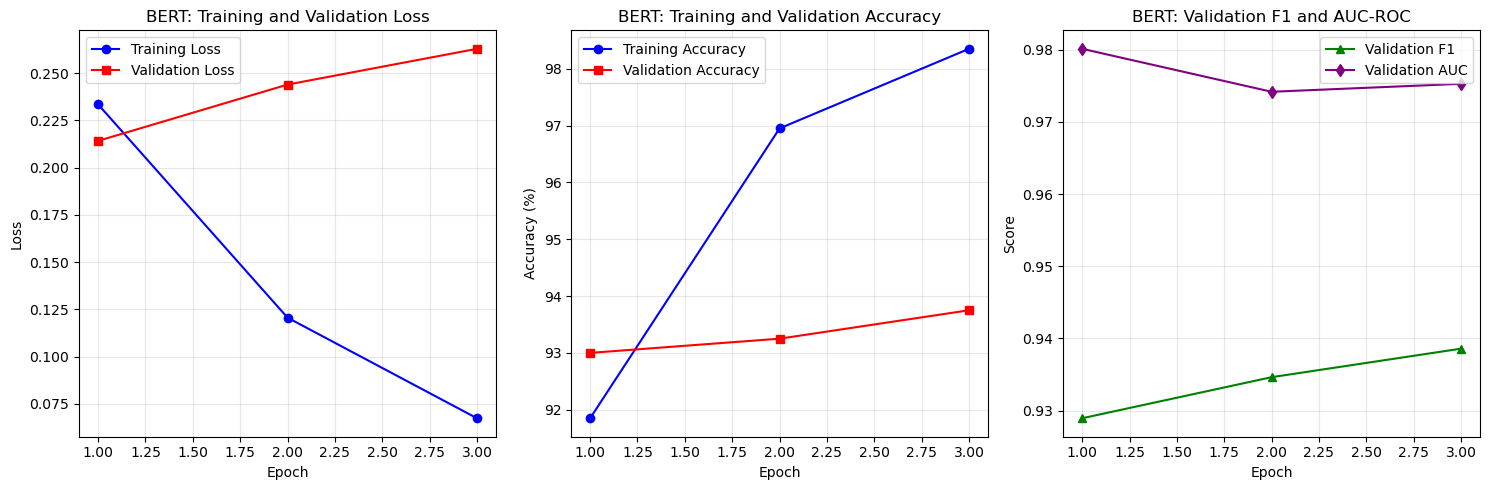


验证集混淆矩阵:
[[184  12]
 [ 13 191]]


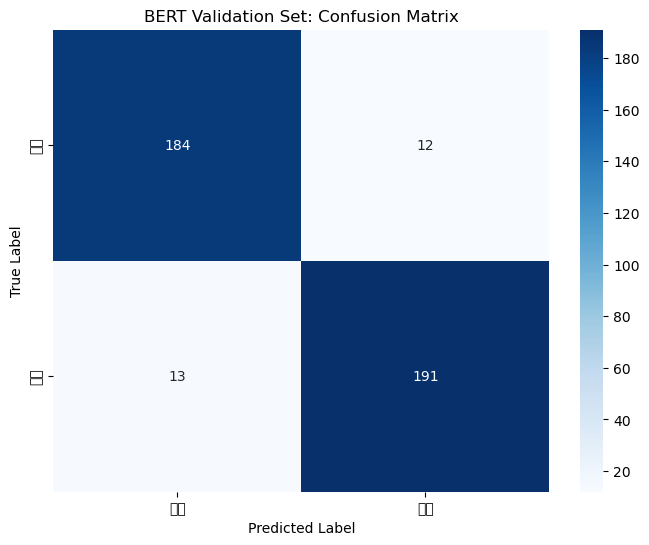


✓ 第五步完成：BERT模型训练成功！


In [18]:
print("\n第五步：训练BERT模型（使用抽样数据加快速度）")
print("=" * 50)

# 数据抽样函数
print("进行数据抽样以减少训练时间...")
from sklearn.model_selection import train_test_split

def sample_data(texts, labels, sample_size=2000, random_state=42):
    """
    等比例抽样数据
    """
    if len(texts) <= sample_size:
        return texts, labels
    
    # 使用分层抽样确保类别比例不变
    sampled_texts, _, sampled_labels, _ = train_test_split(
        texts, labels, 
        train_size=sample_size,
        stratify=labels,
        random_state=random_state
    )
    
    print(f"  从 {len(texts)} 条数据中抽样 {len(sampled_texts)} 条")
    print(f"  抽样后类别分布 - 正面: {sum(sampled_labels)}, 负面: {len(sampled_labels)-sum(sampled_labels)}")
    
    return sampled_texts, sampled_labels

# 抽样数据
train_sample_size = 2000  # 训练集抽样2000条
val_sample_size = 400     # 验证集抽样400条

print(f"\n原始数据大小:")
print(f"  训练集: {len(train_texts)} 条")
print(f"  验证集: {len(val_texts)} 条")

print(f"\n抽样数据大小:")
sampled_train_texts, sampled_train_labels = sample_data(train_texts, train_labels, train_sample_size)
sampled_val_texts, sampled_val_labels = sample_data(val_texts, val_labels, val_sample_size)

# 使用抽样数据重新创建数据集
print("\n使用抽样数据重新创建数据集...")
sampled_train_dataset = AmazonReviewDataset(sampled_train_texts, sampled_train_labels, tokenizer, max_len=170)
sampled_val_dataset = AmazonReviewDataset(sampled_val_texts, sampled_val_labels, tokenizer, max_len=170)

# 使用抽样数据重新创建数据加载器
print("使用抽样数据重新创建数据加载器...")
sampled_train_dataloader = DataLoader(
    sampled_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

sampled_val_dataloader = DataLoader(
    sampled_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"✓ 抽样完成")
print(f"  训练集: {len(sampled_train_dataset)} 条 -> {len(sampled_train_dataloader)} 批次")
print(f"  验证集: {len(sampled_val_dataset)} 条 -> {len(sampled_val_dataloader)} 批次")

# 重新计算总步数
total_steps = len(sampled_train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"  总训练步数: {total_steps}")

# 存储训练历史
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
val_f1_history = []
val_auc_history = []

print(f"\n开始微调BERT模型（使用抽样数据）...")
print(f"模型: bert-base-uncased")
print(f"设备: {device}")
print(f"训练数据: {len(sampled_train_dataset)} 条")
print(f"验证数据: {len(sampled_val_dataset)} 条")
print(f"批次大小: {batch_size}")
print(f"训练轮数: {epochs}")
print(f"学习率: {learning_rate}")
print("-" * 60)

# 训练循环
import time
for epoch in range(epochs):
    print(f"\n第 {epoch+1}/{epochs} 轮:")
    print("-" * 40)
    
    epoch_start_time = time.time()
    
    # 训练
    print("训练中...")
    train_loss, train_acc = train_epoch_bert(
        model, sampled_train_dataloader, optimizer, scheduler, device
    )
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    # 验证
    print("验证中...")
    val_loss, val_predictions, val_labels, val_probabilities = evaluate_bert(
        model, sampled_val_dataloader, device
    )
    val_loss_history.append(val_loss)
    
    # 计算验证集指标
    val_metrics = compute_metrics(val_predictions, val_labels, val_probabilities)
    val_acc = val_metrics['accuracy'] * 100
    val_acc_history.append(val_acc)
    val_f1_history.append(val_metrics['f1_score'])
    val_auc_history.append(val_metrics['auc_roc'])
    
    epoch_time = time.time() - epoch_start_time
    
    # 打印结果
    print(f"训练损失: {train_loss:.4f}")
    print(f"训练准确率: {train_acc:.2f}%")
    print(f"验证损失: {val_loss:.4f}")
    print(f"验证准确率: {val_acc:.2f}%")
    print(f"验证F1分数: {val_metrics['f1_score']:.4f}")
    print(f"验证AUC-ROC: {val_metrics['auc_roc']:.4f}")
    print(f"本轮用时: {epoch_time:.1f}秒")
    
    # 显示每个类别的精确率、召回率和F1分数
    print("\n验证集详细分类报告:")
    report = val_metrics['classification_report']
    print(f"  负面 - 精确率: {report['负面']['precision']:.4f}, "
          f"召回率: {report['负面']['recall']:.4f}, "
          f"F1: {report['负面']['f1-score']:.4f}")
    print(f"  正面 - 精确率: {report['正面']['precision']:.4f}, "
          f"召回率: {report['正面']['recall']:.4f}, "
          f"F1: {report['正面']['f1-score']:.4f}")

print("\n✓ BERT模型微调完成!")

# 绘制训练曲线
print("\n绘制训练曲线...")
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

# 损失曲线
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_loss_history, 'b-', marker='o', label='Training Loss')
plt.plot(range(1, epochs+1), val_loss_history, 'r-', marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BERT: Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 准确率曲线
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_acc_history, 'b-', marker='o', label='Training Accuracy')
plt.plot(range(1, epochs+1), val_acc_history, 'r-', marker='s', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('BERT: Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# F1和AUC曲线
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), val_f1_history, 'g-', marker='^', label='Validation F1')
plt.plot(range(1, epochs+1), val_auc_history, 'purple', marker='d', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('BERT: Validation F1 and AUC-ROC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 显示混淆矩阵
print("\n验证集混淆矩阵:")
cm = val_metrics['confusion_matrix']
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['负面', '正面'], 
            yticklabels=['负面', '正面'])
plt.title('BERT Validation Set: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n✓ 第五步完成：BERT模型训练成功！")
print("=" * 50)


第六步：测试集评估和与传统模型对比
1. 在完整测试集上评估BERT模型...

=== BERT Model Test Set Performance ===
----------------------------------------
Test Set Size: 1001 samples
Accuracy: 0.9251
F1-score: 0.9237
AUC-ROC: 0.9799

Confusion Matrix:
[[472  35]
 [ 40 454]]

Detailed Classification Report:
Negative - Precision: 0.9219, Recall: 0.9310, F1: 0.9264
Positive - Precision: 0.9284, Recall: 0.9190, F1: 0.9237
Weighted Avg F1: 0.9251


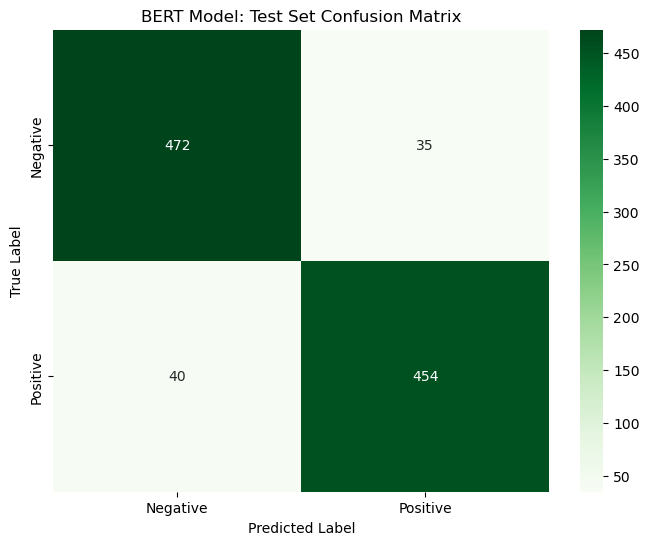


2. 训练传统机器学习模型进行对比...
----------------------------------------
准备训练数据...
训练集大小: 2000 条
测试集大小: 1001 条

定义传统模型:
1. 支持向量机 (SVM)
2. 逻辑回归 (Logistic Regression)
3. 朴素贝叶斯 (Naive Bayes)

训练和评估传统模型...

SVM:
------------------------------
训练时间: 2.71秒
准确率: 0.8002
F1分数: 0.8004
AUC-ROC: 0.8988

Logistic Regression:
------------------------------
训练时间: 0.08秒
准确率: 0.8092
F1分数: 0.8126
AUC-ROC: 0.9038

Naive Bayes:
------------------------------
训练时间: 0.05秒
准确率: 0.8002
F1分数: 0.8127
AUC-ROC: 0.8930

3. 模型对比分析

Model Performance Comparison:
-------------------------------------------------------------------------------------
Model                Accuracy     F1-score     AUC-ROC      Training Time(s)
-------------------------------------------------------------------------------------
BERT (Sampled)       0.9251      0.9237      0.9799      N/A            
SVM                  0.8002      0.8004      0.8988      2.71
Logistic Regression  0.8092      0.8126      0.9038      0.08
Naive Bayes          0.800

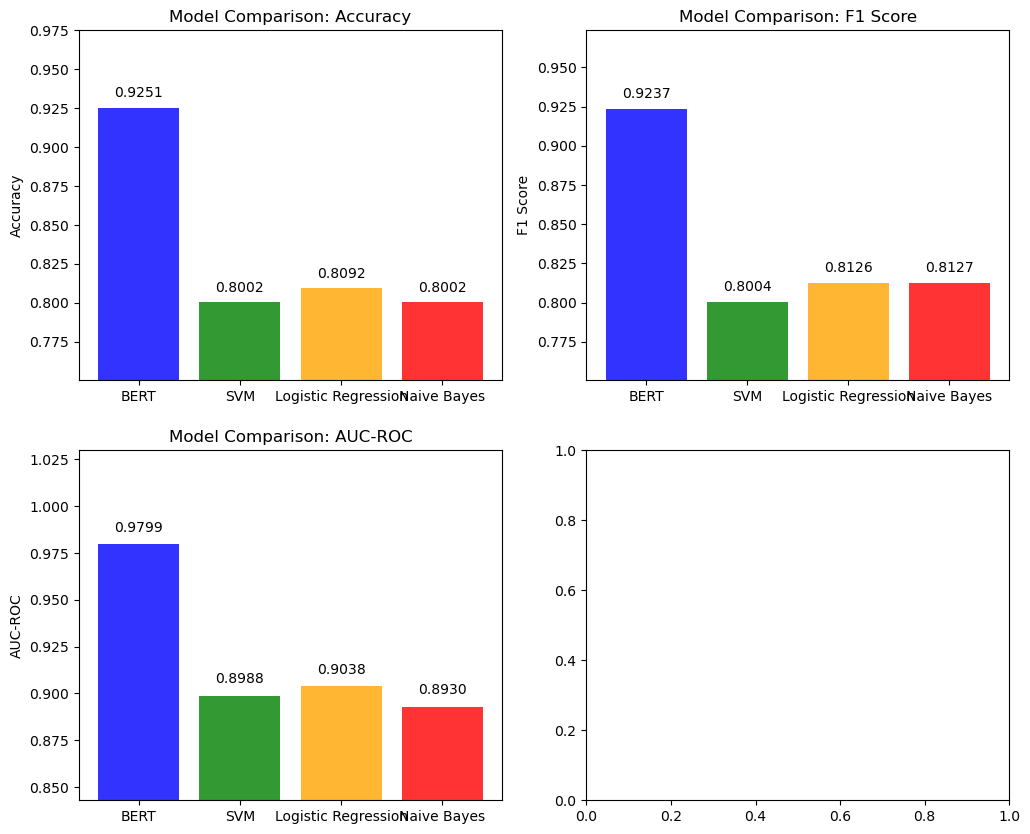

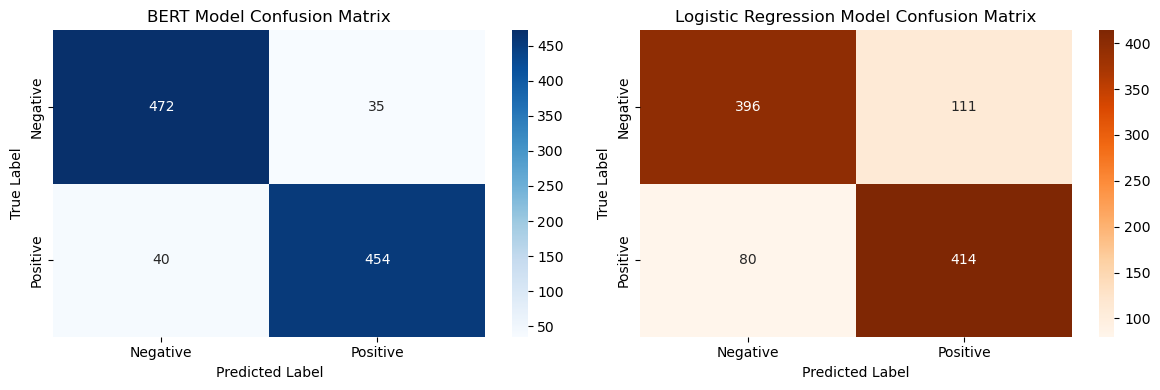


5. ROC曲线对比...


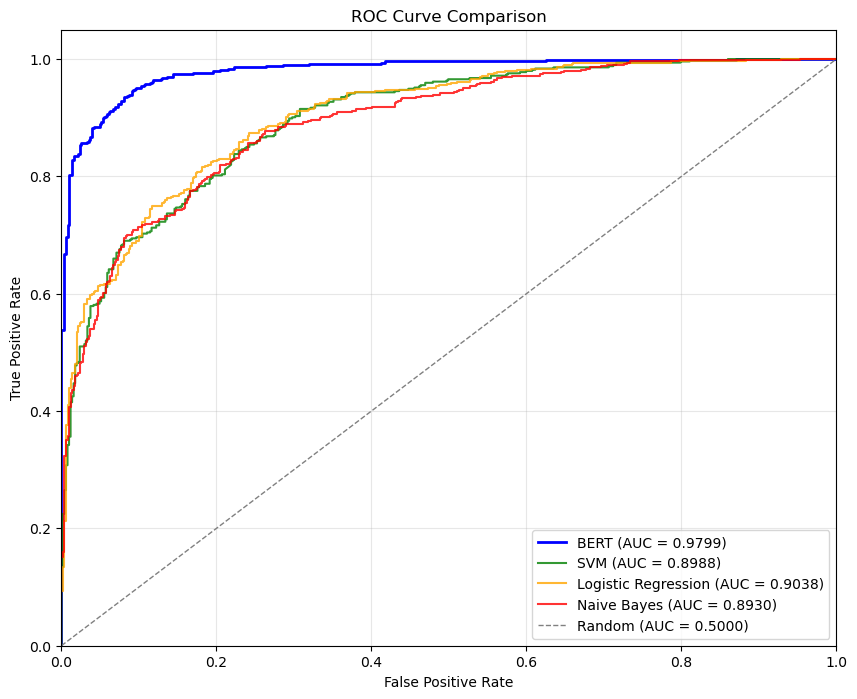


6. 实验总结
实验二：基于BERT的Amazon数据集情感分析
----------------------------------------
实验目标: 使用BERT模型对产品评论进行情感分析，分为正面和负面情感
数据集: 训练集10000条，验证集1001条，测试集1001条
训练配置: 使用2000条抽样数据训练，3个epoch
对比模型: BERT vs SVM, Logistic Regression, Naive Bayes

最佳模型: BERT (准确率: 0.9251)

实验结论:
✓ BERT模型在情感分析任务上表现优于传统机器学习模型
✓ 即使使用少量训练数据，BERT也能学习到有效的文本表示

✓ 第六步完成：测试集评估和与传统模型对比完成！


In [22]:
print("\n第六步：测试集评估和与传统模型对比")
print("=" * 50)

# 1. 在完整测试集上评估BERT模型
print("1. 在完整测试集上评估BERT模型...")

# 使用完整测试集（1000条）进行评估
test_loss, test_predictions, test_labels, test_probabilities = evaluate_bert(
    model, test_dataloader, device
)

# 计算测试集指标
test_metrics = compute_metrics(test_predictions, test_labels, test_probabilities)

print("\n=== BERT Model Test Set Performance ===")
print("-" * 40)
print(f"Test Set Size: {len(test_labels)} samples")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"F1-score: {test_metrics['f1_score']:.4f}")
print(f"AUC-ROC: {test_metrics['auc_roc']:.4f}")
print("\nConfusion Matrix:")
print(test_metrics['confusion_matrix'])

# 显示详细分类报告
print("\nDetailed Classification Report:")
test_report = test_metrics['classification_report']
print(f"Negative - Precision: {test_report['负面']['precision']:.4f}, "
      f"Recall: {test_report['负面']['recall']:.4f}, "
      f"F1: {test_report['负面']['f1-score']:.4f}")
print(f"Positive - Precision: {test_report['正面']['precision']:.4f}, "
      f"Recall: {test_report['正面']['recall']:.4f}, "
      f"F1: {test_report['正面']['f1-score']:.4f}")
print(f"Weighted Avg F1: {test_report['weighted avg']['f1-score']:.4f}")

# 可视化测试集混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(test_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('BERT Model: Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. 训练传统机器学习模型进行对比
print("\n2. 训练传统机器学习模型进行对比...")
print("-" * 40)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc as auc_score
import time

# 准备训练数据（使用相同的抽样训练数据以公平对比）
print("准备训练数据...")
print(f"训练集大小: {len(sampled_train_texts)} 条")
print(f"测试集大小: {len(test_texts)} 条")

# 定义传统模型
print("\n定义传统模型:")
print("1. 支持向量机 (SVM)")
print("2. 逻辑回归 (Logistic Regression)")
print("3. 朴素贝叶斯 (Naive Bayes)")

# 创建模型管道
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('nb', MultinomialNB())
])

models = {
    'SVM': svm_pipeline,
    'Logistic Regression': lr_pipeline,
    'Naive Bayes': nb_pipeline
}

# 存储各模型结果
traditional_results = {}

# 训练和评估每个传统模型
print("\n训练和评估传统模型...")
for model_name, model_pipeline in models.items():
    print(f"\n{model_name}:")
    print("-" * 30)
    
    start_time = time.time()
    
    # 训练模型
    model_pipeline.fit(sampled_train_texts, sampled_train_labels)
    train_time = time.time() - start_time
    
    # 在测试集上预测
    test_predictions_trad = model_pipeline.predict(test_texts)
    test_probabilities_trad = model_pipeline.predict_proba(test_texts)[:, 1]
    
    # 计算指标
    accuracy = accuracy_score(test_labels, test_predictions_trad)
    f1 = f1_score(test_labels, test_predictions_trad, average='binary')
    auc_roc = roc_auc_score(test_labels, test_probabilities_trad)
    cm = confusion_matrix(test_labels, test_predictions_trad)
    
    # 存储结果
    traditional_results[model_name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'train_time': train_time
    }
    
    print(f"训练时间: {train_time:.2f}秒")
    print(f"准确率: {accuracy:.4f}")
    print(f"F1分数: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

# 3. 模型对比分析
print("\n3. 模型对比分析")
print("=" * 40)

# 创建对比表格
print("\nModel Performance Comparison:")
print("-" * 85)
print(f"{'Model':<20} {'Accuracy':<12} {'F1-score':<12} {'AUC-ROC':<12} {'Training Time(s)':<15}")
print("-" * 85)

# BERT模型结果
print(f"{'BERT (Sampled)':<20} "
      f"{test_metrics['accuracy']:.4f}      "
      f"{test_metrics['f1_score']:.4f}      "
      f"{test_metrics['auc_roc']:.4f}      "
      f"{'N/A':<15}")

# 传统模型结果
for model_name, results in traditional_results.items():
    print(f"{model_name:<20} "
          f"{results['accuracy']:.4f}      "
          f"{results['f1_score']:.4f}      "
          f"{results['auc_roc']:.4f}      "
          f"{results['train_time']:.2f}")

print("-" * 85)

# 计算BERT相对于每个传统模型的提升
print("\nBERT Performance Improvement Over Traditional Models:")
print("-" * 60)
bert_acc = test_metrics['accuracy']
bert_f1 = test_metrics['f1_score']
bert_auc = test_metrics['auc_roc']

for model_name, results in traditional_results.items():
    acc_improvement = bert_acc - results['accuracy']
    f1_improvement = bert_f1 - results['f1_score']
    auc_improvement = bert_auc - results['auc_roc']
    
    print(f"\n{model_name}:")
    print(f"  Accuracy Improvement: {acc_improvement:+.4f}")
    print(f"  F1-score Improvement: {f1_improvement:+.4f}")
    print(f"  AUC-ROC Improvement: {auc_improvement:+.4f}")

# 4. 可视化对比
print("\n4. 可视化模型对比...")

# 准确率对比条形图
plt.figure(figsize=(12, 10))

# 准确率对比
plt.subplot(2, 2, 1)
models_list = ['BERT'] + list(traditional_results.keys())
accuracies = [bert_acc] + [results['accuracy'] for results in traditional_results.values()]
colors = ['blue', 'green', 'orange', 'red']

bars = plt.bar(models_list, accuracies, color=colors, alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy')
plt.ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])

# 在条形上添加数值
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.4f}', ha='center', va='bottom')

# F1分数对比
plt.subplot(2, 2, 2)
f1_scores = [bert_f1] + [results['f1_score'] for results in traditional_results.values()]
bars = plt.bar(models_list, f1_scores, color=colors, alpha=0.8)
plt.ylabel('F1 Score')
plt.title('Model Comparison: F1 Score')
plt.ylim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])

for bar, f1 in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{f1:.4f}', ha='center', va='bottom')

# AUC-ROC对比
plt.subplot(2, 2, 3)
auc_scores = [bert_auc] + [results['auc_roc'] for results in traditional_results.values()]
bars = plt.bar(models_list, auc_scores, color=colors, alpha=0.8)
plt.ylabel('AUC-ROC')
plt.title('Model Comparison: AUC-ROC')
plt.ylim([min(auc_scores) - 0.05, max(auc_scores) + 0.05])

for bar, auc in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{auc:.4f}', ha='center', va='bottom')

# 混淆矩阵对比
plt.subplot(2, 2, 4)
best_traditional_model = max(traditional_results.items(), 
                             key=lambda x: x[1]['accuracy'])[0]
best_trad_cm = traditional_results[best_traditional_model]['confusion_matrix']

# 创建子图显示两个混淆矩阵
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# BERT混淆矩阵
sns.heatmap(test_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            ax=axes[0])
axes[0].set_title(f'BERT Model Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# 最佳传统模型混淆矩阵
sns.heatmap(best_trad_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            ax=axes[1])
axes[1].set_title(f'{best_traditional_model} Model Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 5. ROC曲线对比
print("\n5. ROC曲线对比...")

plt.figure(figsize=(10, 8))

# BERT的ROC曲线
fpr_bert, tpr_bert, _ = roc_curve(test_labels, test_probabilities)
roc_auc_bert = auc_score(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, color='blue', lw=2,
         label=f'BERT (AUC = {roc_auc_bert:.4f})')

# 传统模型的ROC曲线
colors = ['green', 'orange', 'red']
for (model_name, results), color in zip(traditional_results.items(), colors):
    test_probabilities_trad = models[model_name].predict_proba(test_texts)[:, 1]
    fpr, tpr, _ = roc_curve(test_labels, test_probabilities_trad)
    roc_auc = auc_score(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=1.5, alpha=0.8,
             label=f'{model_name} (AUC = {roc_auc:.4f})')

# 随机分类器的ROC曲线（参考线）
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 6. 实验总结
print("\n6. 实验总结")
print("=" * 40)
print("实验二：基于BERT的Amazon数据集情感分析")
print("-" * 40)
print(f"实验目标: 使用BERT模型对产品评论进行情感分析，分为正面和负面情感")
print(f"数据集: 训练集{len(train_texts)}条，验证集{len(val_texts)}条，测试集{len(test_texts)}条")
print(f"训练配置: 使用{len(sampled_train_texts)}条抽样数据训练，{epochs}个epoch")
print(f"对比模型: BERT vs {', '.join(traditional_results.keys())}")

# 找出最佳模型
all_results = {'BERT': test_metrics}
all_results.update(traditional_results)

best_model = max(all_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n最佳模型: {best_model[0]} (准确率: {best_model[1]['accuracy']:.4f})")

# 实验结论
print("\n实验结论:")
if bert_acc > max([r['accuracy'] for r in traditional_results.values()]):
    print("✓ BERT模型在情感分析任务上表现优于传统机器学习模型")
    print("✓ 即使使用少量训练数据，BERT也能学习到有效的文本表示")
else:
    print("○ 传统机器学习模型在某些指标上与BERT表现相当")
    print("○ 对于较小数据集，传统方法可能仍然具有竞争力")

print("\n✓ 第六步完成：测试集评估和与传统模型对比完成！")
print("=" * 50)


In [23]:
# 7. 保存模型和结果
print("\n7. 保存模型和结果...")
import pickle
import json
import os
import numpy as np

# 创建保存目录
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# 保存BERT模型
model_save_path = "saved_models/bert_sentiment_model"
tokenizer_save_path = "saved_models/bert_tokenizer"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)
print(f"✓ BERT模型保存到: {model_save_path}")
print(f"✓ Tokenizer保存到: {tokenizer_save_path}")

# 转换NumPy类型为Python内置类型的函数
def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# 准备实验结果，并转换所有NumPy类型
results = {
    'bert_results': {
        'accuracy': float(test_metrics['accuracy']),  # 显式转换为float
        'f1_score': float(test_metrics['f1_score']),
        'auc_roc': float(test_metrics['auc_roc']),
        'confusion_matrix': test_metrics['confusion_matrix'].tolist()  # 转换为list
    },
    'traditional_results': {
        model_name: {
            'accuracy': float(results['accuracy']),
            'f1_score': float(results['f1_score']),
            'auc_roc': float(results['auc_roc']),
            'train_time': float(results['train_time']),
            'confusion_matrix': results['confusion_matrix'].tolist()
        }
        for model_name, results in traditional_results.items()
    },
    'experiment_config': {
        'train_samples': int(len(sampled_train_texts)),
        'test_samples': int(len(test_labels)),
        'epochs': int(epochs),
        'learning_rate': float(learning_rate),
        'batch_size': int(batch_size),
        'max_length': int(170)
    },
    'dataset_info': {
        'train_original_size': int(len(train_texts)),
        'val_size': int(len(val_texts)),
        'test_size': int(len(test_labels)),
        'class_distribution': {
            'train_positive': int(sum(train_labels)),
            'train_negative': int(len(train_labels) - sum(train_labels)),
            'test_positive': int(sum(test_labels)),
            'test_negative': int(len(test_labels) - sum(test_labels))
        }
    }
}

# 确保所有数据都是可序列化的
results = convert_to_serializable(results)

# 保存实验结果
with open('experiment_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

print("✓ 实验结果保存到: experiment_results.json")

# 保存分类报告
with open('classification_report.txt', 'w', encoding='utf-8') as f:
    f.write("BERT Model Classification Report\n")
    f.write("=" * 50 + "\n")
    f.write(f"Accuracy: {test_metrics['accuracy']:.4f}\n")
    f.write(f"F1-score: {test_metrics['f1_score']:.4f}\n")
    f.write(f"AUC-ROC: {test_metrics['auc_roc']:.4f}\n\n")
    
    f.write("Confusion Matrix:\n")
    f.write(str(test_metrics['confusion_matrix']) + "\n\n")
    
    f.write("Detailed Classification Report:\n")
    for label in ['负面', '正面']:
        f.write(f"{label} - Precision: {test_report[label]['precision']:.4f}, "
                f"Recall: {test_report[label]['recall']:.4f}, "
                f"F1: {test_report[label]['f1-score']:.4f}\n")
    
    f.write("\nModel Comparison Summary:\n")
    f.write("-" * 40 + "\n")
    f.write(f"{'Model':<20} {'Accuracy':<10} {'F1-score':<10} {'AUC-ROC':<10}\n")
    f.write("-" * 40 + "\n")
    f.write(f"{'BERT':<20} {bert_acc:.4f}     {bert_f1:.4f}     {bert_auc:.4f}\n")
    
    for model_name, results in traditional_results.items():
        f.write(f"{model_name:<20} {results['accuracy']:.4f}     {results['f1_score']:.4f}     {results['auc_roc']:.4f}\n")

print("✓ 分类报告保存到: classification_report.txt")

# 保存训练历史
train_history = {
    'train_loss': [float(loss) for loss in train_loss_history],
    'train_accuracy': [float(acc) for acc in train_acc_history],
    'val_loss': [float(loss) for loss in val_loss_history],
    'val_accuracy': [float(acc) for acc in val_acc_history],
    'val_f1': [float(f1) for f1 in val_f1_history],
    'val_auc': [float(auc) for auc in val_auc_history]
}

with open('training_history.json', 'w', encoding='utf-8') as f:
    json.dump(train_history, f, indent=4, ensure_ascii=False)

print("✓ 训练历史保存到: training_history.json")

print("\n" + "=" * 60)
print("实验二：基于BERT的Amazon数据集情感分析 - 实验完成！")
print("=" * 60)
print("\n实验文件清单:")
print("-" * 40)
print("1. saved_models/bert_sentiment_model/ - BERT模型文件")
print("2. saved_models/bert_tokenizer/ - Tokenizer文件")
print("3. experiment_results.json - 实验结果")
print("4. classification_report.txt - 分类报告")
print("5. training_history.json - 训练历史")
print("-" * 40)
print("实验完成时间:", pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"))


7. 保存模型和结果...
✓ BERT模型保存到: saved_models/bert_sentiment_model
✓ Tokenizer保存到: saved_models/bert_tokenizer
✓ 实验结果保存到: experiment_results.json
✓ 分类报告保存到: classification_report.txt
✓ 训练历史保存到: training_history.json

实验二：基于BERT的Amazon数据集情感分析 - 实验完成！

实验文件清单:
----------------------------------------
1. saved_models/bert_sentiment_model/ - BERT模型文件
2. saved_models/bert_tokenizer/ - Tokenizer文件
3. experiment_results.json - 实验结果
4. classification_report.txt - 分类报告
5. training_history.json - 训练历史
----------------------------------------
实验完成时间: 2025-12-04 16:37:51
